# IMPORTS

In [1]:
import pandas as pd
import os
from tabulate import tabulate
from pandarallel import pandarallel
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# CONFIGURATION

In [2]:
# PREVIEW PHASE
PREVIEW_SIZE = 1000

# EXTRACT PHASE
CHUNK_SIZE = 100000
EXTRACT_PARQUET = False

# ANALYSE PHASE
SAMPLING_SIZE = 1000

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
PREFIX_YELP = 'yelp_academic_dataset_'

# FONCTIONS

In [28]:
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Name', 'Size']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df

def get_words_max_frequency(reviews: pd.DataFrame, max_frequency = 1):
    words = {}
    for index in reviews.index:
        for token in reviews.loc[index, 'tokens']:
            if not token in words:
                words[token] = 1
            else:
                words[token] = words[token] + 1
    under = [token for token, count in words.items() if count <= max_frequency]
    upper = [token for token, count in words.items() if count > max_frequency]
    
    return [token for token, count in words.items() if count <= max_frequency], len(upper)      

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # normalization
    text = text.lower()

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Stops Words
    stops = stopwords.words('english')
    tokens = [token for token in tokens if not token in stops]

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    return tokens

def word_cloud(text):
    wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

# PREVISUALISATION DES DATASETS

In [4]:
files = list_files(ORIGINAL_DATASET_DIR, print_result=False)
files

{'business': 'data/original/yelp_dataset/yelp_academic_dataset_business.json',
 'checkin': 'data/original/yelp_dataset/yelp_academic_dataset_checkin.json',
 'review': 'data/original/yelp_dataset/yelp_academic_dataset_review.json',
 'tip': 'data/original/yelp_dataset/yelp_academic_dataset_tip.json',
 'user': 'data/original/yelp_dataset/yelp_academic_dataset_user.json'}

In [5]:
preview_dfs = {}
for name in files:
    print(f'PREVIEW {name}\n=====================\n')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

PREVIEW business



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
135,qdYfHRsZdcz4Bun4f9Ijaw,Norristown Car Wash,10 E Germantown Pike,Norristown,PA,19401,40.140914,-75.312315,2.0,8,1,{'BusinessAcceptsCreditCards': 'True'},"Car Wash, Auto Detailing, Automotive",None
322,DeN5N6B78gysROm_Sq2kWA,Little V.I.P's Preschool,318 E Browning Rd,Bellmawr,NJ,08031,39.865426,-75.068073,3.5,7,1,None,"Education, Preschools, Local Services, Child C...","{'Monday': '6:30-18:0', 'Tuesday': '6:30-18:0'..."
483,VKwPAl11iuM_YkEwm07sYQ,Hibiscus Spa,400 Mandalay Ave,Clearwater,FL,33767,27.978877,-82.827961,4.5,14,1,"{'WiFi': 'u'free'', 'ByAppointmentOnly': 'Fals...","Day Spas, Beauty & Spas, Hair Salons","{'Monday': '10:0-16:0', 'Tuesday': '10:0-16:0'..."
833,QjHGUvMNwb2NOidfcd1zLw,Oak Motors,3931 S E St,Indianapolis,IN,46227,39.708536,-86.148084,2.0,9,1,{'BusinessAcceptsCreditCards': 'True'},"Car Dealers, Auto Repair, Automotive, Used Car...","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'..."
470,VeFfrEZ4iWaecrQg6Eq4cg,Cal Taco,"7320 Hollister Ave, Ste 1",Goleta,CA,93117,34.430542,-119.882367,4.0,189,1,"{'RestaurantsGoodForGroups': 'True', 'Business...","Burgers, Cafes, Restaurants, Mexican, American...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-20:30', ..."


business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


PREVIEW checkin



,business_id,date
285,-7SlRxSWoLDB5YaYlcNpSg,"2016-10-25 08:42:59, 2016-10-26 07:06:32, 2017..."
499,-DsC3cvCBEy_FNJ7U-i9zg,"2010-04-07 16:54:45, 2010-04-27 16:06:34, 2010..."
697,-KUu_Rl4UepNCIyWTJYbow,"2014-02-06 23:40:16, 2014-03-25 16:28:21, 2014..."
311,-85kJMtb9wqNWDT8yLbitw,"2010-09-05 16:47:18, 2010-10-01 14:55:24, 2010..."
446,-CJaGFoVnofRPKwl4NJaLg,"2012-07-16 20:50:45, 2015-12-17 23:24:56, 2016..."


business_id    object
date           object
dtype: object


PREVIEW review



,review_id,user_id,business_id,stars,useful,funny,cool,text,date
176,x-1wBBwja9l2Hr5bgqsG0A,L-2Qdi16eMRbATGDP6ADHg,mQvRi0nm84Www71d4qOheQ,5,1,0,1,Excellent food. We tried three appetizers and ...,2016-07-03 21:13:10
768,9qCZxJnJTSm1rvrAj2O6Og,ftXAwWq5_3AMSzVviheQSQ,gKPWC7F219oEbu5NXPzH4g,4,0,0,0,Our second favorite place to watch a sunset. I...,2015-07-03 22:49:14
955,UVyf-nDeSNrpJsDpbHJZGg,wMRABJye-vljUZxI2y7YTA,3pCdFDNxXEKCW0Y_r77Qpg,5,1,0,0,the best frozen yogurt i have found in the cen...,2012-12-04 22:35:11
194,_u331rYIp7qJ7aWvLup9Ug,BUpAhzsbbKbTqyBjT8YnNQ,wa_bwyY57etHjtJ2Fw0E3g,5,0,0,0,Called in a Mediterranean chicken shawarma. Go...,2014-04-01 05:00:09
772,5QXoOzlXejer6vBhLWkrbw,MEyPvp4jfT0qwsbR2kNepg,NT5S6JV5wPwKOd3s3Yh1zQ,3,2,0,0,"I would eat here again, but mostly because it ...",2014-10-11 12:10:26


review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


PREVIEW tip



,user_id,business_id,text,date,compliment_count
370,1bjo-xG3tKF5rQjRx5zW4Q,CsZJYRcHFzkhqGBBnoIKaA,Lovely locally-grown strawberries. If you can...,2015-06-02 13:44:56,0
176,wJ57oQxkmdN2Milto9nOmw,KuQIzjzwhqykR3CMwqNBTA,Take your food to go it's too Hot inside with ...,2016-08-06 23:10:39,0
712,aWWU_LEDET6nW3AU8i08vA,WbxPdq_PgVvCI462l0vPEQ,I always get great service even if they are ou...,2013-05-28 02:54:01,0
206,ZSmUmmJ9Jxk3UeaVmWg4Eg,RkA7wLIxPweJn0HgLSNjHw,This place is fantastic!! The food is deliciou...,2018-03-24 23:28:57,0
329,NCK5nbNOxDD-730AHYdt1Q,WB-eQAgw88fbr15eY761CA,Always ask Spartaco for the evening's specials,2012-10-09 23:10:01,0


user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object


PREVIEW user



,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
456,0MP38Eo_X45oHNvcKTLkRA,Andrew,20,2007-08-14 16:06:36,45,12,24,,"ci-mepWGgsgGT3sFI2mhMg, kFMhZYjbQ6r_K9yMCcG_ig...",5,...,0,0,1,0,1,1,3,3,0,1
227,aA0WQpDdksKuDafTGzJf_A,Warren,161,2007-05-06 22:48:26,410,211,221,"2007,2008,2009","qvmL6mp-rpIwVguxb5HuvQ, uDgz8pNy--SQm6Ae3uRiFg...",23,...,6,4,1,12,12,13,19,19,8,1
358,a6myQnEM2qdJMWcYqOQWlg,Judith,68,2006-07-22 14:46:15,87,25,37,,"BwuWVhAbU8uOQzN37PlO0A, 6Mv-qMJyxSokCu8YFM1o0A...",2,...,2,0,0,0,2,4,1,1,0,0
510,m1LzN8vRCuJYwrDfJA0fiw,Joe,27,2009-07-05 20:22:46,40,8,14,,"NMYtvhWWUuq8H3Jcu0ZF-w, hNJCY3goUx7opXmP5ioVBQ...",1,...,1,0,0,0,1,1,0,0,0,0
396,LJhQx48XHLggMDxkX4bePw,A,137,2007-06-19 03:02:43,504,224,308,,"2RtR1KrM1L85-KShwZ-9Kg, 4lacVJ97kY6Ofqibmx08AA...",5,...,2,0,4,0,3,6,10,10,1,0


user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

<Axes: xlabel='stars'>

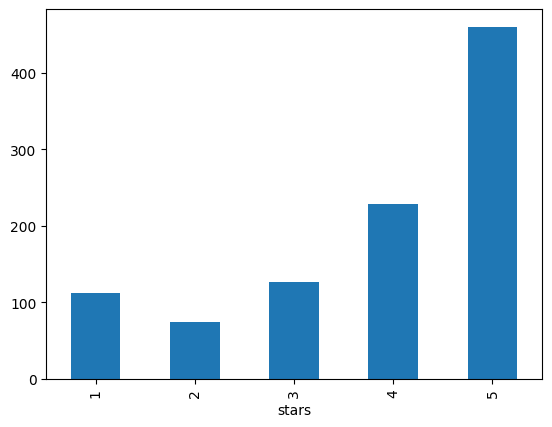

In [6]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar()

In [7]:
preview_dfs['business']['categories'].unique()[0:20]

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
       'Brewpubs, Breweries, Food',
       'Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants',
       'Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories',
       'Synagogues, Religious Organizations',
       'Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek',
       'Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food',
       'Department Stores, Shopping, Fashion',
       'Vietnamese, Food, Restaurants, Food Trucks',
       'American (Traditional), Restaurants, Diners, Breakfast & Brunch',
       'General Dentistry, Dentists, Health & Medic

In [8]:
review = preview_dfs['review']
for star in range(1,6):
    print(f'Note = {star}:\n=========\n')
    for index in review[review['stars']==star].sample(4, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        print(f'{text}\n\n')

Note = 1:

They have the WORST service advisors! Used to be good before Kelly and her team left. Unfortunately, it's convenient to work if I need oil change before I can make it to another Honda dealer.


It is unfortunate that with such a unique location and such a brand and product offering this specific store offers such lousy service. The wait is endless, no one is available to help and at Christmas time getting a gift wrap is act of God that requires endless wait. I bought gifts and knew that the wait for wrapping would be long SO I even left my items at the store to be gift wrapped at their leisure. They were not even moved from the counter where I bought them when I returned almost two hours later ready for pick up. This was a gift that needed to be given and The staff COMPLETELY "dropped the ball" on my time constraints! 

I love their stuff, but today was my last shopping experience at this location: couldn't get a gift wrapped after being assured that it could be done in a ti

<Axes: xlabel='class'>

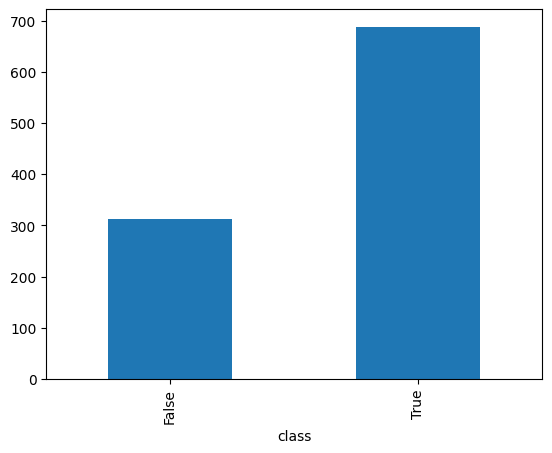

In [9]:
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > 3
preview_dfs['review']['class'].value_counts().sort_index().plot.bar()

# EXTRACTION GOOD/BAD REVIEWS DES RESTAURANTS

## CATEGORIES DE BUSINESS

In [10]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

65046    [Nurseries & Gardening, Home Services, Lawn Se...
58888    [Automotive, Auto Repair, Body Shops, Auto Det...
95459                    [Burgers, Restaurants, Fast Food]
77103    [Seafood Markets, Food, Restaurants, Seafood, ...
33572    [Flooring, Home Services, Carpet Installation,...
Name: _cats, dtype: object

In [11]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [12]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Pop-Up Restaurants', 'Restaurants', 'Restaurant Supplies']

In [13]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Food Banks',
 'Ethnic Food',
 'Specialty Food',
 'Food Stands',
 'Do-It-Yourself Food',
 'Food Delivery Services',
 'Food Tours',
 'Imported Food',
 'Seafood Markets',
 'Seafood',
 'Food',
 'Food Trucks',
 'Soul Food',
 'Food Court',
 'Fast Food',
 'Comfort Food',
 'Live/Raw Food']

## REDUCTION DU DATAFRAME REVIEW ET SAUVEGARDE

- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation en bad/good reviews (bad <= stars = 3 < good)
- Ne garder que text et séparer en 2 fichiers good/bad news

In [14]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
restaurants_ids[0:10]

['MTSW4McQd7CbVtyjqoe9mw',
 'CF33F8-E6oudUQ46HnavjQ',
 'k0hlBqXX-Bt0vf1op7Jr1w',
 'bBDDEgkFA1Otx9Lfe7BZUQ',
 'eEOYSgkmpB90uNA7lDOMRA',
 'il_Ro8jwPlHresjw9EGmBg',
 '0bPLkL0QhhPO5kt1_EXmNQ',
 'MUTTqe8uqyMdBl186RmNeA',
 'ROeacJQwBeh05Rqg7F6TCg',
 'WKMJwqnfZKsAae75RMP6jA']

In [15]:
append = False
good_reviews_file = WORK_DATASET_DIR + 'good_reviews.parquet'
bad_reviews_file = WORK_DATASET_DIR + 'bad_reviews.parquet'

if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=100000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews['class'] = restaurant_reviews['stars'] > 3
        restaurant_reviews = restaurant_reviews.loc[:, ['text', 'class']]
    
        good_reviews = pd.DataFrame(restaurant_reviews[restaurant_reviews['class'] == True]['text'])
        bad_reviews = pd.DataFrame(restaurant_reviews[restaurant_reviews['class'] == False]['text'])
    
        good_reviews.to_parquet(good_reviews_file, engine='fastparquet', append=append)
        bad_reviews.to_parquet(bad_reviews_file, engine='fastparquet', append=append)
        append = True

# TOKENIZATION ET ANALYSE DES BAD REVIEWS 

In [26]:
def treat_reviews(reviews_file, min_words_frequency = 4):

    # load dataframe and display head
    reviews = pd.read_parquet(reviews_file)
    display(reviews.head())

    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=True)
    if SAMPLING_SIZE:
        reviews = reviews.sample(SAMPLING_SIZE, random_state=0)
    
    # Preprocess (tokenize, lower, lemmatization)
    reviews['tokens'] = reviews['text'].parallel_apply(preprocess_text)
    reviews.drop(columns=['text'], inplace=True)
    
    # Remove words by frequency
    words_to_drop, nb_tokens = get_words_max_frequency(reviews, min_words_frequency - 1)
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(words_to_drop,))

    # View result sample
    display(reviews.sample(5))

    # Calc and view text lengths
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()
    reviews.boxplot(column='text_len', showfliers=True)

    total_text_len = reviews['text_len'].sum()

    print(f'Nombre de tokens dans le dataframe: {nb_tokens}')
    print(f'Longeur total du texte dans le dataframe: {total_text_len}')
    print('')

    # Visualisation Word clound on sample
    sample_text = ' '.join(reviews.sample(SAMPLING_SIZE, random_state=0)['tokens'].str.join(' ').values)
    word_cloud(text=sample_text)

,text
index,
0,"If you decide to eat here, just be aware it is..."
2,Family diner. Had the buffet. Eclectic assortm...
5,I am a long term frequent customer of this est...
9,Had a party of 6 here for hibachi. Our waitres...
21,"Upland is a brewery based out of Bloomington, ..."


INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,tokens
index,
3199178,"[boyfriend, come, day, read, lot, review, yelp..."
1902719,"[one, bad, experience, restaurant, one, waitre..."
5691249,"[good, solid, staff, high, within, 3, 4, visit..."
1187580,"[yesterday, daughter, stop, honest, expensive,..."
1105989,"[sorry, miss, eat, dinner, come, like, late, a..."


Nombre de tokens dans le dataframe: 1683
Longeur total du texte dans le dataframe: 324980



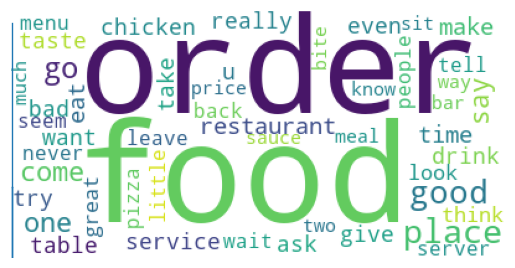

In [30]:
treat_reviews(bad_reviews_file, 5)